# MySQL AI
MySQL AI provides developers to build rich applications with MySQL leveraging built in machine learning, GenAI, LLMs and semantic search. They can create vectors from documents stored in a local file system. Customers can deploy these AI applications on premise or migrate them to MySQL HeatWave for lower cost, higher performance, richer functionality and latest LLMs with no change to their application. This gives developers the flexibility to build their applications on MySQL EE and then deploy them either on premise or in the cloud.

### Machine Learning with MovieLens Dataset Notebook
This notebook explores the application of recommender system techniques using the MovieLens dataset, one of the most iconic and widely adopted benchmarks in recommender systems research.

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
  - 100,000 ratings (1-5) from 943 users on 1682 movies. 
  - Each user has rated at least 20 movies. 
    - Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

  - The user may not state or imply any endorsement from the University of Minnesota or the GroupLens Research Group.

  - The user must acknowledge the use of the data set in publications resulting from the use of the data set.

  - The user may not redistribute the data without separate permission.

  - The user may not use this information for any commercial or revenue-bearing purposes without first obtaining permission from a faculty member of the GroupLens Research Project at the University of Minnesota.

The ml-100k dataset includes the following key files:
- u.data (ratings): Contains user–item interactions in the form

    user_id | item_id | rating | timestamp (tab-separated).

- u.item (movies): Contains metadata such as movie titles, release dates, IMDb URLs, and genre indicators (binary flags across multiple genres).
- u.user (users): Contains demographic information for each user (age, gender, occupation, zip code).
- Additional files (e.g., u.genre, u.info) provide auxiliary context and dataset metadata

This notebook delves into the application of MySQL AI AutoML for building a personalized movie recommendation system using the MovieLens 100K dataset.


### References
- https://blogs.oracle.com/mysql/post/announcing-mysql-ai
- https://dev.mysql.com/doc/mysql-ai/9.4/en/
- https://dev.mysql.com/doc/dev/mysql-studio/latest/#overview


### Prerequistises

- mysql-connector-python
- pandas 
- scikit-learn
- sqlalchemy
- matplotlib

In [1]:
import os
import json
import zipfile
import shutil
import numpy as np
import pandas as pd
import sqlalchemy
import mysql.connector
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Connect to MySQL AI instance
We create a connection to an active MySQL AI instance using the [MySQL Connector/Python](https://dev.mysql.com/doc/connector-python/en/). We also define an API to execute a SQL query using a cursor, and the result is returned as a Pandas DataFrame. Modify the below variables to point to your MySQL AI instance.

 - In MySQL Studio, connections are restricted to only allow localhost as the host. 
 - In MySQL Studio, the only accepted password values are the string unused or None. 

In [ ]:
HOST = 'localhost'
PORT = 3306
USER = 'root'
PASSWORD = 'unused'
SCHEMA = 'mlcorpus'


myconn = mysql.connector.connect(
    host=HOST,
    port=PORT,
    user=USER,
    password=PASSWORD,
    database=SCHEMA,
    allow_local_infile=True,
    use_pure=True,
    autocommit=True,
)
mycursor = myconn.cursor()


# Helper function to execute SQL queries and return the results as a Pandas DataFrame
def execute_sql(sql: str) -> pd.DataFrame:
    mycursor.execute(sql)
    return pd.DataFrame(mycursor.fetchall(), columns=mycursor.column_names)

 ### Download the MovieLens dataset and load it into Python
 Download the MovieLens dataset from [GroupLens](https://grouplens.org/datasets/movielens/) and upload into My Files folder in MySQL AI Studio.
 
 You can use the follwing curl command to download the dataset:
 
 curl -O "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

 We extract the zipfile, and load into Python using Pandas.

In [4]:
path = "/workspace/datasets/"
zip_path = "ml-100k.zip"

# Extract the dataset
with zipfile.ZipFile(os.path.join(path, zip_path), "r") as zip_ref:
    zip_ref.extractall(path)

# Load the ratings file (u.data)
extract_dir = path + "ml-100k"
cols = ["user_id", "movie_id", "rating", "timestamp"]
df = pd.read_csv(os.path.join(extract_dir, "u.data"), 
                      sep="\t", names=cols, encoding="utf-8")

df["user_id"] = df["user_id"].astype("object")
df["movie_id"] = df["movie_id"].astype("object")

# Now that we have loaded the data in Python, we don't need the local files anymore
shutil.rmtree(extract_dir)

### Split the data into a training set and an evaluation set
In machine learning, the train-test split is a crucial technique used to evaluate the performance of a model on unseen data. It involves dividing the available dataset into two distinct subsets:   

- Training set: This subset is used to train the machine learning model. The model learns the underlying patterns and relationships in the data by analyzing this set.   
- Test set: This subset is held back and not used during the training process. Once the model is trained, it's applied to the test set to assess its ability to generalize to new, unseen data.

In [5]:
df_train, df_test = train_test_split(
    df, test_size=0.30, random_state=1, stratify=df["rating"]
)

 ### Load the MovieLens dataset into MySQL tables
 We connect to the MySQL AI instance using SQLAlchemy, map Pandas data types to their corresponding MySQL dialects, and writes two DataFrames (df_train and df_test) to separate tables (movielens_train and movielens_test) in the MySQL, replacing any existing tables.

In [6]:
# Create a SQLAlchemy engine instance to connect to the MySQL database
sql_engine = sqlalchemy.create_engine(
    f"mysql+mysqlconnector://{USER}:{PASSWORD}@{HOST}:{PORT}/{SCHEMA}",
    echo=False,
    echo_pool=False,
    pool_pre_ping=True,
    pool_recycle=3600,
)

# Define a dictionary mapping pandas data types to their corresponding SQLAlchemy dialects
dtype_mapping = {
    "uint64": sqlalchemy.dialects.mysql.INTEGER(unsigned=True),
    "int64": sqlalchemy.dialects.mysql.INTEGER(),
    "float64": sqlalchemy.dialects.mysql.FLOAT(),
    "object": sqlalchemy.dialects.mysql.VARCHAR(length=255),
    "datetime64[ns]": sqlalchemy.dialects.mysql.DATETIME(timezone=False),
    "bool": sqlalchemy.dialects.mysql.TINYINT(),
}
# Prepare the dtype dict for sqlalchemy/pd.DataFrame.to_sql
dtypes = {col: dtype_mapping[str(dtype)] for col, dtype in zip(df.columns, df.dtypes)}

# Write the training DataFrame to the 'movielens_train' table in the database
df_train.to_sql(
    f"movielens_train",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)
# Write the testing DataFrame to the 'movielens_test' table in the database
df_test.to_sql(
    f"movielens_test",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)

-6

### Create a AutoML model from the MovieLens training dataset
We create a machine learning model on the MovieLens dataset using the [ML_TRAIN](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-train.html) API. The target variable for this model is the rating column, which represents the explicit ratings provided by users for various movies. By specifying rating as the target, the model aims to learn the underlying patterns that determine how users rate movies. This enables the generation of personalized recommendations for unseen movies based on user preferences. The model handle generated at the end of training is stored in the model variable. We will use this handle to refer to the model in our future interactions

In [7]:
execute_sql("""SET @model = NULL;""")
execute_sql(
    f"""CALL sys.ML_TRAIN('{SCHEMA}.movielens_train', 'rating', JSON_OBJECT('task', 'recommendation', 'users', 'user_id', 'items', 'movie_id'), @model)"""
)
model = execute_sql("""SELECT @model;""").iat[0,0]
execute_sql(f"""CALL sys.ML_MODEL_LOAD('{model}', NULL)""")

""


### Evaluate the model
We look at the overall performance of the model on unseen data by using the [ML_SCORE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-score.html) routine. It allows us to quantify the quality of the predictions. The user needs to provide which metrics he wants to use. 

For Recommender Systems, the possible metrics are: 
- neg_mean_squared_error
- neg_root_mean_squared_error
- neg_mean_absolute_error
- r2

The result is stored in the @score variable. 

In [9]:
execute_sql(
    f"""CALL sys.ML_SCORE('{SCHEMA}.movielens_test', 'rating', '{model}', 'neg_mean_squared_error', @score, NULL);"""
)
score = execute_sql("""SELECT @score;""").iat[0,0]
print(f"The model score is {score:.2f}")

The model score is -0.86


### Generating predictions to evaluate model performance on unseen test data
We invoke the [ML_PREDICT_TABLE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-predict-table.html) API to generate prediction for the above model on our test data. The output table contains an extra column ml_results which contins the predicted ratings.

In [10]:
execute_sql(f"""DROP TABLE IF EXISTS movielens_test_test_predictions""")
execute_sql(
    f"""CALL sys.ML_PREDICT_TABLE('{SCHEMA}.movielens_test', '{model}', '{SCHEMA}.movielens_test_test_predictions', JSON_OBJECT("recommend", "ratings"))"""
)
df_predictions = execute_sql(f"""SELECT * FROM movielens_test_test_predictions""")
execute_sql(f"""DROP TABLE IF EXISTS movielens_test_test_predictions""")
df_predictions.head()

,_4aad19ca6e_pk_id,user_id,movie_id,rating,timestamp,ml_results
0,1,655,942,4,888685850,"{""predictions"": {""rating"": 2.95}}"
1,2,21,299,1,874950931,"{""predictions"": {""rating"": 2.55}}"
2,3,114,195,4,881260861,"{""predictions"": {""rating"": 3.52}}"
3,4,416,140,4,886317030,"{""predictions"": {""rating"": 3.38}}"
4,5,303,147,4,879467816,"{""predictions"": {""rating"": 3.54}}"


### Getting a deeper understanding of the model's predictions

Let's visualize how close the predictions are to the real ratings.

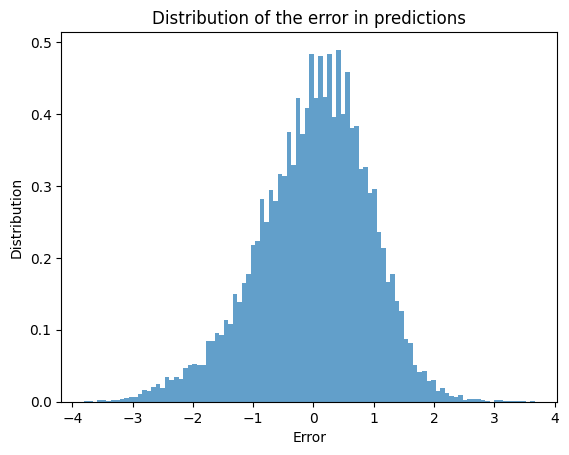

In [11]:
predicted_ratings = df_predictions['ml_results'].apply(json.loads).apply(lambda x: x["predictions"]).apply(pd.Series)
ratings = df_predictions[["rating"]]

difference = (ratings- predicted_ratings).values
num_bins = 100
plt.hist(difference, num_bins,  density = 1, alpha = 0.7)
plt.xlabel('Error')
plt.ylabel('Distribution')
plt.title('Distribution of the error in predictions')
plt.show()

We invite you to try [HeatWave AutoML and GenAI](https://www.oracle.com/heatwave/free/). If you’re new to Oracle Cloud Infrastructure, try Oracle Cloud Free Trial, a free 30-day trial with US$300 in credits.